# Importing Libraries

In [10]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import awkward as ak


# Loading Root Files Into Pandas Dataframes

In [11]:
# replace this with a path to the WC ntuple files
wc_file_location = "/Users/leehagaman/data/processed_checkout_rootfiles/"

# let's open a nu_overlay file and examine the contents

f_nu_overlay = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run1_PF.root")
f_nu_overlay.keys()


['wcpselection;1',
 'wcpselection/T_PFeval;69',
 'wcpselection/T_PFeval;68',
 'wcpselection/T_BDTvars;13',
 'wcpselection/T_BDTvars;12',
 'wcpselection/T_eval;2',
 'wcpselection/T_eval;1',
 'wcpselection/T_pot;1',
 'wcpselection/T_KINEvars;1']

### We see that there are several TTrees inside the wcpselection TDirectory. Now let's print the variables in each TTree.

In [12]:
already_printed_keys = []

for key in f_nu_overlay["wcpselection"].items():
    key_name = key[0].split(";")[0]
    if key_name not in already_printed_keys: # sometimes a TTree is repeated, we ignore duplicates
        print("\nPrinting variables in TTree: ", key[0].split(";")[0])
        print(f_nu_overlay["wcpselection"][key[0]].keys())
        already_printed_keys.append(key_name)


Printing variables in TTree:  T_PFeval
['run', 'subrun', 'event', 'neutrino_type', 'reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ', 'reco_showervtxX', 'reco_showervtxY', 'reco_showervtxZ', 'reco_showerKE', 'reco_muonvtxX', 'reco_muonvtxY', 'reco_muonvtxZ', 'reco_muonMomentum', 'nuvtx_diff', 'showervtx_diff', 'muonvtx_diff', 'truth_corr_nuvtxX', 'truth_corr_nuvtxY', 'truth_corr_nuvtxZ', 'truth_corr_showervtxX', 'truth_corr_showervtxY', 'truth_corr_showervtxZ', 'truth_showerKE', 'truth_corr_muonvtxX', 'truth_corr_muonvtxY', 'truth_corr_muonvtxZ', 'truth_muonvtxX', 'truth_muonvtxY', 'truth_muonvtxZ', 'truth_muonendX', 'truth_muonendY', 'truth_muonendZ', 'truth_muonMomentum', 'truth_nuEnergy', 'truth_energyInside', 'truth_electronInside', 'truth_nuPdg', 'truth_isCC', 'truth_vtxX', 'truth_vtxY', 'truth_vtxZ', 'truth_nuTime', 'truth_nuIntType', 'truth_NCDelta', 'truth_NprimPio', 'truth_pio_energy_1', 'truth_pio_energy_2', 'truth_pio_angle', 'reco_protonMomentum', 'reco_showerMomentum', 'reco_Np

### That's a lot of variables! Let's only load a few of the most relevant ones for now.

## Choosing Variables To Load

In [13]:
T_bdt_vars = [              # variables involved with BDT training (if you want to train your own BDT, lots of these variables will be useful)
    "nue_score",                    # BDT score for nue selection, used for the WC inclusive nueCC analysis
    "numu_score",                   # BDT score for numu selection, used for the WC inclusive numuCC selections
    "nc_delta_score",               # BDT score for NC Delta selection
    "nc_pio_score",                 # BDT score for NC pi0 selection
]

T_eval_vars = [             # variables involved with low level reconstruction and truth information
    "run",                          # run number
    "subrun",                       # subrun number
    "event",                        # event number
    "match_isFC",                   # reconstructed cluster is fully contained (FC), boolean
    "truth_nuEnergy",               # true neutrino energy (MeV)
    "truth_nuPdg",                  # true neutrino pdg code
    "truth_isCC",                   # true interaction type is charged current, boolean
    "match_completeness_energy",    # the true energy deposited in the clusters that are 3D-matched with the reconstructed neutrino clusters (MeV)
    "truth_energyInside",           # the true energy deposited in the TPC Fiducial Volume (MeV)
    "truth_vtxInside",              # boolean, true neutrino vertex is inside the TPC Fiducial Volume
    "truth_vtxX",                   # true neutrino vertex x (cm)
    "truth_vtxY",                   # true neutrino vertex y (cm)
    "truth_vtxZ",                   # true neutrino vertex z (cm)
    "weight_cv",                    # untuned GENIE event weight
    "weight_spline",                # additional MicroBooNE Tune weight
]
T_eval_data_vars = [        # same as above, but for data files we do not attempt to load any truth information
    "run",
    "subrun",
    "event",
    "match_isFC",
]

T_kine_vars = [             # variables involved with kinematic reconstruction
    "kine_reco_Enu",                # reconstructed neutrino energy (MeV)   
]

T_pf_vars = [               # variables involved with individual particles
    "truth_NprimPio",
    "truth_NCDelta",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",            # reconstructed muon momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)

    # These variables are related to individual true particles
    "truth_Ntrack",
    "truth_id",
    "truth_pdg",
    "truth_mother",
    "truth_startMomentum",
    "truth_startXYZT",
    "truth_endXYZT",

    # These variables are related to individual reco particles
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]
T_pf_data_vars = [          # same as above, but for data files we do not attempt to load any truth information
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]


## Making Dataframes

In [14]:
print("loading root files...")

f = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"] # loading the nu_overlay file
vars = {}
vars.update(f["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["T_eval"].arrays(T_eval_vars, library="np"))
vars.update(f["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["T_PFeval"].arrays(T_pf_vars, library="np"))
nu_overlay_file_POT = np.sum(f["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
for col in vars:
    vars[col] = vars[col].tolist()
nu_overlay_df = pd.DataFrame(vars)
nu_overlay_df["file"] = "nu_overlay"
print(f"loaded nu_overlay file, {len(nu_overlay_df)} events, {nu_overlay_file_POT:.4e} POT")

f = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run1_PF.root")["wcpselection"]
vars = {}
vars.update(f["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["T_eval"].arrays(T_eval_data_vars, library="np"))
vars.update(f["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["T_PFeval"].arrays(T_pf_data_vars, library="np"))
dirt_file_POT = np.sum(f["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
dirt_vars = {}
for col in vars:
    dirt_vars[col] = vars[col].tolist()
dirt_df = pd.DataFrame(dirt_vars)
dirt_df["file"] = "dirt"
print(f"loaded dirt file, {len(dirt_df)} events")

f = uproot.open(wc_file_location + "checkout_data_extbnb_run1_PF.root")["wcpselection"]
vars = {}
vars.update(f["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["T_eval"].arrays(T_eval_data_vars, library="np"))
vars.update(f["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["T_PFeval"].arrays(T_pf_data_vars, library="np"))
ext_vars = {}
for col in vars:
    ext_vars[col] = vars[col].tolist()
ext_df = pd.DataFrame(ext_vars)
ext_df["file"] = "ext"
print(f"loaded ext file, {len(ext_df)} events")

f = uproot.open(wc_file_location + "checkout_data_bnb_run1_PF.root")["wcpselection"]
vars = {}
vars.update(f["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["T_eval"].arrays(T_eval_data_vars, library="np"))
vars.update(f["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["T_PFeval"].arrays(T_pf_data_vars, library="np"))
data_vars = {}
for col in vars:
    data_vars[col] = vars[col].tolist()
data_df = pd.DataFrame(data_vars)
data_df["file"] = "data"
print(f"loaded data file, {len(data_df)} events")

print("concatenating prediction dataframes...")
pred_df = pd.concat([nu_overlay_df, dirt_df, ext_df], axis=0, ignore_index=True)
del nu_overlay_df, dirt_df, ext_df
print("done!")

pred_df


loading root files...
loaded nu_overlay file, 581941 events, 7.1457e+20 POT
loaded dirt file, 332957 events
loaded ext file, 633290 events
loaded data file, 544769 events
concatenating prediction dataframes...
done!


,nue_score,numu_score,nc_delta_score,nc_pio_score,run,subrun,event,match_isFC,truth_nuEnergy,truth_nuPdg,...,truth_startXYZT,truth_endXYZT,reco_Ntrack,reco_id,reco_pdg,reco_mother,reco_startMomentum,reco_startXYZT,reco_endXYZT,file
0,-7.811869,2.852163,-8.818343,-3.941474,6219,97,4867,False,1489.831421,14.0,...,"[[87.71574, -109.88016, 951.88165, 3606.5874],...","[[152.58669, -143.1937, 1004.5534, 3610.174], ...",22,"[65001, 65002, 65007, 65004, 66008, 67009, 680...","[13, 2212, 11, 11, 11, 2212, 11, 211, 211, 211...","[0, 0, 0, 0, 66022, 67023, 68024, 69025, 70026...","[[0.10423357, -0.054070458, 0.10593233, 0.1901...","[[87.59615, -109.97093, 951.8236, 0.0], [87.59...","[[104.48816, -115.216835, 967.583, 0.0], [85.6...",nu_overlay
1,-15.000000,-3.340668,-2.275953,-1.729817,6219,97,4869,False,728.165955,14.0,...,"[[56.76709, -93.32467, 143.59035, 4205.8667], ...","[[26.711618, -118.74195, 138.23914, 4207.5776]...",0,[],[],[],[],[],[],nu_overlay
2,-15.000000,-3.821578,-2.275953,-1.729817,6219,97,4896,True,710.893616,14.0,...,"[[3.4733982, 43.196075, 649.0427, 3803.2844], ...","[[-3.043216, 48.873753, 651.61237, 3803.8103],...",0,[],[],[],[],[],[],nu_overlay
3,-15.000000,-3.821578,-2.275953,-1.729817,6219,97,4899,True,1149.019531,14.0,...,"[[200.43024, -148.55887, 371.23663, 4208.3276]...","[[27.655361, -139.20549, 537.4116, 4217.0684],...",0,[],[],[],[],[],[],nu_overlay
4,-15.000000,-3.821578,-2.275953,-1.729817,6219,99,4967,True,889.859497,14.0,...,"[[213.08461, 116.4394, 723.33325, 3512.1108], ...","[[-25952.285, 53000.0, 22924.432, 5613.6997], ...",0,[],[],[],[],[],[],nu_overlay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548183,-15.000000,-3.340668,-2.275953,-1.729817,6749,207,10365,False,NaN,NaN,...,NaN,NaN,0,[],[],[],[],[],[],ext
1548184,-15.000000,-3.340668,-2.275953,-1.729817,6749,207,10367,False,NaN,NaN,...,NaN,NaN,0,[],[],[],[],[],[],ext
1548185,-15.000000,-3.340668,-2.275953,-1.729817,6749,207,10368,False,NaN,NaN,...,NaN,NaN,0,[],[],[],[],[],[],ext
1548186,-15.000000,-3.340668,-2.275953,-1.729817,6749,207,10381,False,NaN,NaN,...,NaN,NaN,0,[],[],[],[],[],[],ext


## Assigning XS and POT Weights

In [15]:
# these are calculated from querying the POT database, and looking at the saved POT and spill numbers. 
# Don't use the T_pot tree for data files!
data_POT = 1.42319e20
ext_POT = 2.21814e20

weight_cv_arr = pred_df["weight_cv"]
weight_spline_arr = pred_df["weight_spline"]
file_arr = pred_df["file"]

net_weights = []
for i in tqdm(range(len(weight_cv_arr))):

    weight_temp = weight_cv_arr[i] * weight_spline_arr[i]
    if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved weights, set it to one
        weight_temp = 1.

    if file_arr[i] == "nu_overlay":
        net_weights.append(weight_temp * data_POT / nu_overlay_file_POT)
    elif file_arr[i] == "dirt":
        net_weights.append(weight_temp * data_POT / dirt_file_POT)
    elif file_arr[i] == "ext":
        net_weights.append(data_POT / ext_POT)
    else:
        raise ValueError(f"Unknown file: {file_arr[i]}")

pred_df["net_weight"] = net_weights


  0%|          | 0/1548188 [00:00<?, ?it/s]

# Making A Histogram

In [16]:
"""x_variable = "kine_reco_Enu"
x_variable_name = "Reconstructed Neutrino Energy (MeV)"
bins = np.linspace(0, 2500, 26)

# name for legend, query to choose predicted events, color 
# (I recommend the Color Highlight VS Code extension to see the hex color in the editor)
breakdown_categories = [
    "Dirt",                 "file=='dirt'",                                                                                                                                                     "#99ccfe",
    "Ext",                  "file=='ext'",                                                                                                                                                      "#ff6666",
    "Bad Match",            "file=='nu_overlay' and match_completeness_energy< 0.1*truth_energyInside",                                                                                         "#ff6666",
    "Out-FV",               "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==0",                                                                  "#6666ff",
    r"NC$\pi^0$",           "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio>0",                           "#ff6666",
    r"$\nu_\mu$CC$\pi^0$",  "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==1 and truth_NprimPio>0 and abs(truth_nuPdg)==14",  "#ff6666",
    r"$\nu_e$CC",           "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==12",                       "#6666ff",
    r"Other $\nu_\mu$CC",   "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio==0", "#ff6666",
    "Other NC",             "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio==0",                          "#ff6666",
]

names = breakdown_categories[::3]
queries = breakdown_categories[1::3]
colors = breakdown_categories[2::3]
num_categories = len(names)

bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2
bins = np.append(bins, 1e9) # adding overflow bin
bin_centers = np.append(bin_centers, bin_centers[-1]+bin_width)

plt.figure(figsize=(10, 6))
plt.hist(
"""

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_61203/1979449733.py:1: SyntaxWarning: invalid escape sequence '\p'
  """x_variable = "kine_reco_Enu"


'x_variable = "kine_reco_Enu"\nx_variable_name = "Reconstructed Neutrino Energy (MeV)"\nbins = np.linspace(0, 2500, 26)\n\n# name for legend, query to choose predicted events, color \n# (I recommend the Color Highlight VS Code extension to see the hex color in the editor)\nbreakdown_categories = [\n    "Dirt",                 "file==\'dirt\'",                                                                                                                                                     "#99ccfe",\n    "Ext",                  "file==\'ext\'",                                                                                                                                                      "#ff6666",\n    "Bad Match",            "file==\'nu_overlay\' and match_completeness_energy< 0.1*truth_energyInside",                                                                                         "#ff6666",\n    "Out-FV",               "file==\'nu_overlay\' and match_completeness_energy>=0

In [17]:
"""

# NC Pi0 Np
axs[0, 0].hist([bin_centers, bin_centers, bin_centers, bin_centers, bin_centers], weights = [nc_pi0_Np_sig_counts, nc_pi0_Np_ccpi0_bkg_counts, nc_pi0_Np_outFV_bkg_counts, nc_pi0_Np_nu_bkg_counts, nc_pi0_Np_ext_bkg_counts], 
               bins=bins, stacked=True, 
               color=colors)
axs[0, 0].hist([bin_centers, bin_centers, bin_centers, bin_centers, bin_centers], weights = [nc_pi0_Np_sig_counts, nc_pi0_Np_ccpi0_bkg_counts, nc_pi0_Np_outFV_bkg_counts, nc_pi0_Np_nu_bkg_counts, nc_pi0_Np_ext_bkg_counts], 
               bins=bins, stacked=True,
               histtype="step", lw=0.7, color=["k", "k", "k", "k", "k"])
axs[0, 0].hist(bin_centers, weights=python_nc_pi0_Np_total_counts, bins=bins, histtype="step", lw=1, color="k")
for i in range(len(bin_centers)):
    if i==0:
        axs[0, 0].add_patch(Rectangle((bins[i], nc_pi0_Np_total_counts[i]-nc_pi0_Np_error[i]), bin_width, 2*nc_pi0_Np_error[i], hatch="/////", fill=False, color="k", lw=0, 
                                      label="Syst. Uncert."))
    else:
        axs[0, 0].add_patch(Rectangle((bins[i], nc_pi0_Np_total_counts[i]-nc_pi0_Np_error[i]), bin_width, 2*nc_pi0_Np_error[i], hatch="/////", fill=False, color="k", lw=0))
axs[0, 0].scatter(bin_centers, nc_pi0_Np_data_counts, color="black", s=10)
axs[0, 0].errorbar(bin_centers, nc_pi0_Np_data_counts, xerr=bin_width/2, yerr=np.sqrt(nc_pi0_Np_data_counts), color="black", fmt="none", capsize=3)
axs[0, 0].text(0.6, 0.7, r"NC $\boldsymbol{\pi}^{\boldsymbol{0}}$ Np", transform=axs[0, 0].transAxes, fontsize=20, verticalalignment='top')

"""


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_61203/2622379436.py:1: SyntaxWarning: invalid escape sequence '\p'
  """


'\n\n# NC Pi0 Np\naxs[0, 0].hist([bin_centers, bin_centers, bin_centers, bin_centers, bin_centers], weights = [nc_pi0_Np_sig_counts, nc_pi0_Np_ccpi0_bkg_counts, nc_pi0_Np_outFV_bkg_counts, nc_pi0_Np_nu_bkg_counts, nc_pi0_Np_ext_bkg_counts], \n               bins=bins, stacked=True, \n               color=colors)\naxs[0, 0].hist([bin_centers, bin_centers, bin_centers, bin_centers, bin_centers], weights = [nc_pi0_Np_sig_counts, nc_pi0_Np_ccpi0_bkg_counts, nc_pi0_Np_outFV_bkg_counts, nc_pi0_Np_nu_bkg_counts, nc_pi0_Np_ext_bkg_counts], \n               bins=bins, stacked=True,\n               histtype="step", lw=0.7, color=["k", "k", "k", "k", "k"])\naxs[0, 0].hist(bin_centers, weights=python_nc_pi0_Np_total_counts, bins=bins, histtype="step", lw=1, color="k")\nfor i in range(len(bin_centers)):\n    if i==0:\n        axs[0, 0].add_patch(Rectangle((bins[i], nc_pi0_Np_total_counts[i]-nc_pi0_Np_error[i]), bin_width, 2*nc_pi0_Np_error[i], hatch="/////", fill=False, color="k", lw=0, \n         

# Plotting An Efficiency

# Particle-level Information

# Particle-level Trees

,file,run,subrun,event,kine_reco_Enu,truth_nuEnergy,nue_score,numu_score,nc_delta_score,nc_pio_score
14341,nu_overlay,7003,45,2269,342.795685,622.154663,-inf,-1.065909,-6.5076,5.170193


Reconstructed Particle Tree:

pi0 126.13 MeV
    gamma 187.23 MeV
        e- 187.23 MeV
    gamma 130.43 MeV
        e- 130.43 MeV
n 4.25 MeV
    p 4.25 MeV
n 18.32 MeV
    p 18.32 MeV
n 2.57 MeV
    p 2.57 MeV
n 0.00 MeV
    p 0.00 MeV

Truth Particle Tree:

nu(mu) 266.73 MeV
p 3.84 MeV
p 1.07 MeV
p 15.13 MeV
p 2.28 MeV
p 8.91 MeV
p 4.58 MeV
n 6.45 MeV
    n 2.09 MeV
        n 0.54 MeV
        Ar40 -9.12 MeV
    Ar40 -8.98 MeV
n 15.28 MeV
    n 0.71 MeV
    n 0.29 MeV
    Ar39 -8.77 MeV
n 6.05 MeV
    n 2.70 MeV
        Cr53 -12.12 MeV
        Ar40 -9.05 MeV
    Ar40 -9.00 MeV
n 19.98 MeV
    Ar40 -9.06 MeV
    n 4.34 MeV
        n 1.22 MeV
            Ar40 -9.07 MeV
            Ar40 -9.09 MeV
        Ar40 -9.14 MeV
    n 1.76 MeV
        Ar40 -9.09 MeV
        Ar40 -9.07 MeV
        Ar40 -9.07 MeV
        Ar40 -9.11 MeV
        Ar40 -9.10 MeV
        Ar40 -9.09 MeV
        Ar40 -9.11 MeV
        Ar40 -9.11 MeV
        p 0.07 MeV
        p 0.11 MeV
    Ar39 -8.89 MeV
n 0.88 MeV
n 9.29

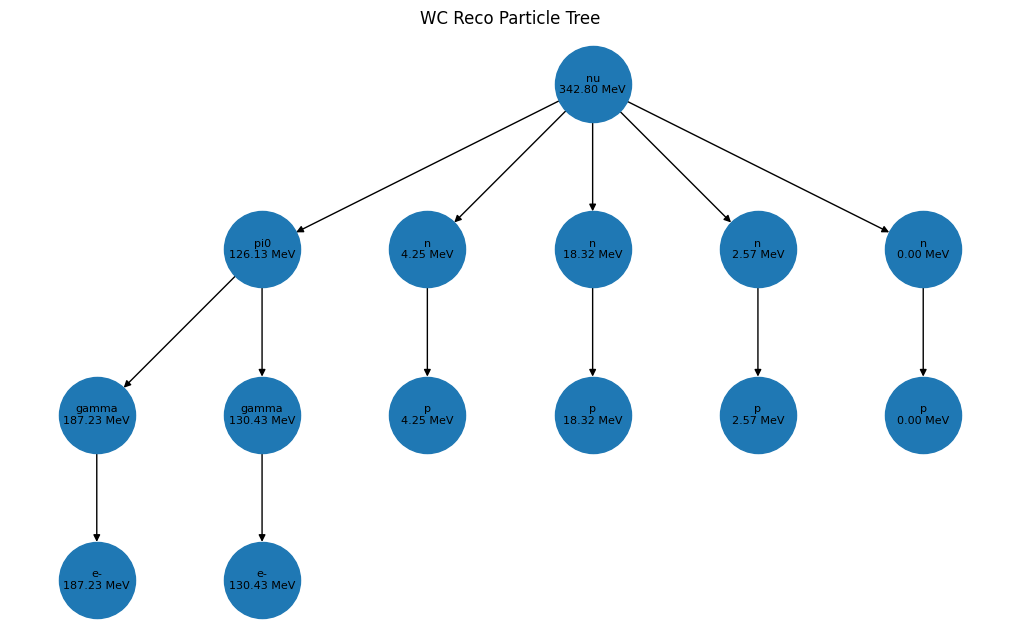

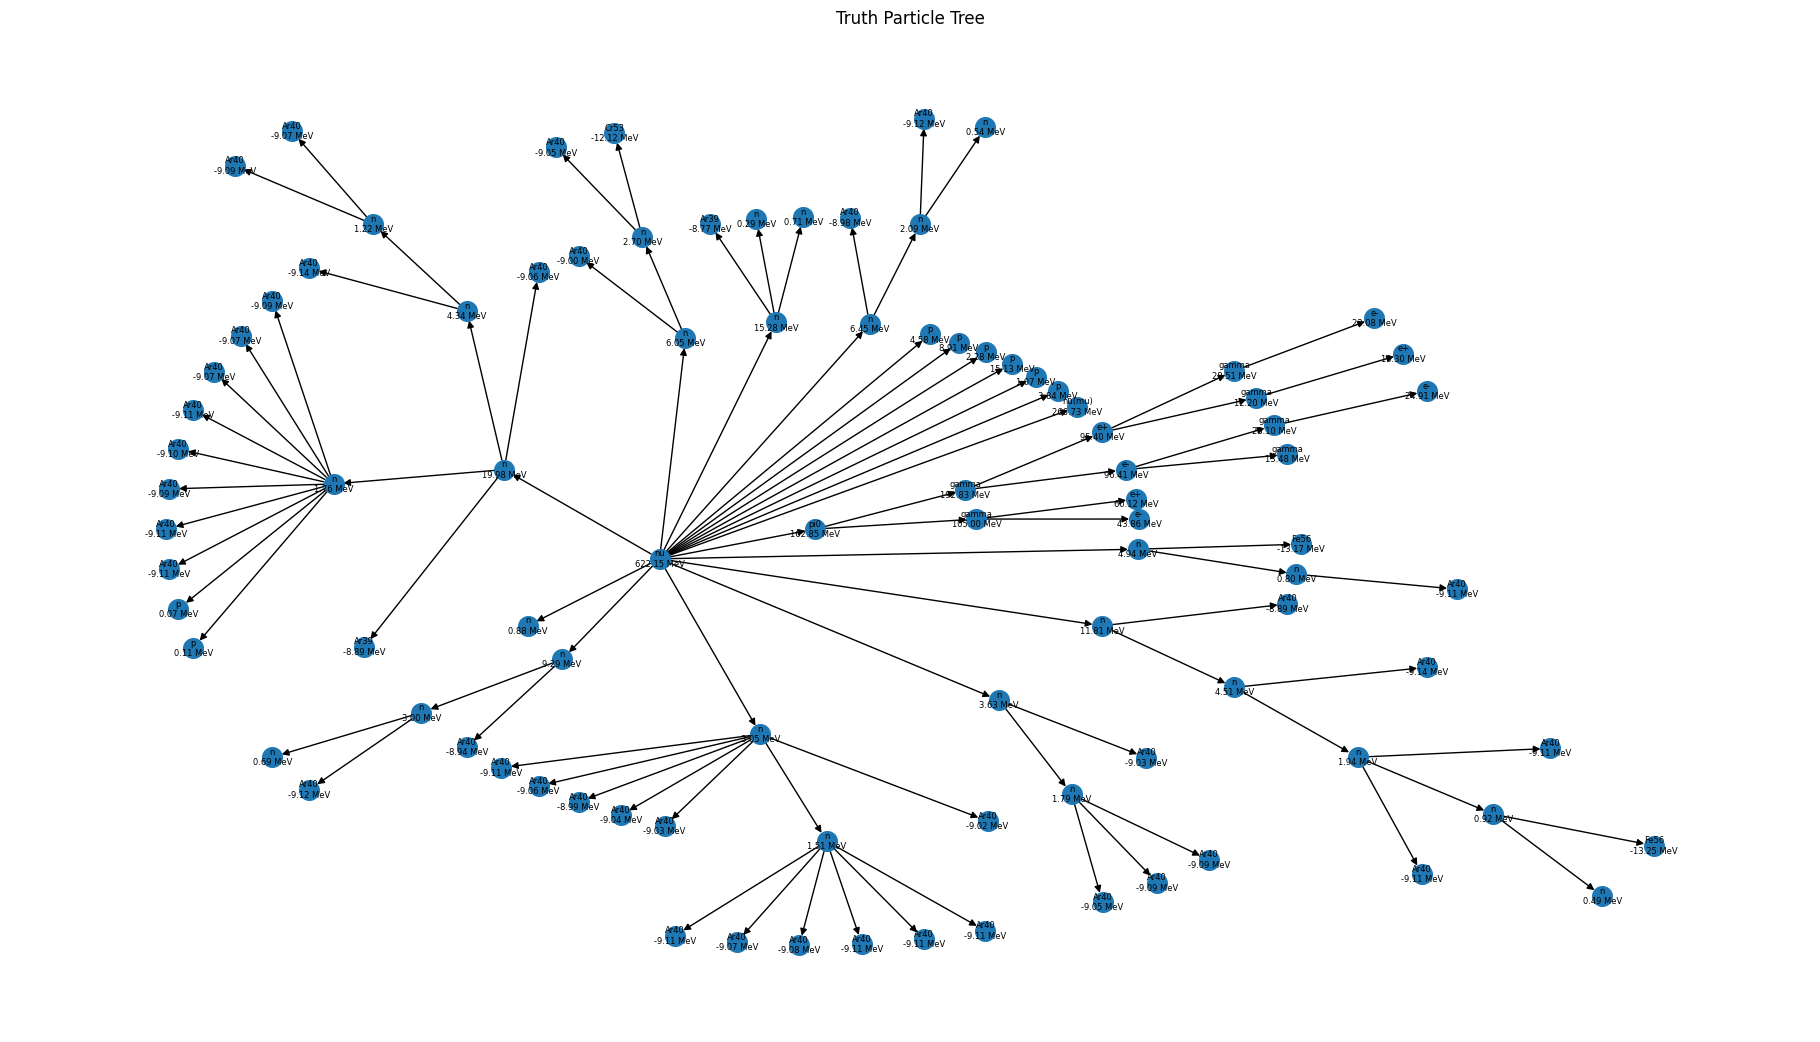

In [18]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from particle import Particle

one_event_df = pred_df.query("file=='nu_overlay' and run==7003 and subrun==45 and event==2269")	

display(one_event_df[["file", "run", "subrun", "event", "kine_reco_Enu", "truth_nuEnergy", "nue_score", "numu_score", "nc_delta_score", "nc_pio_score"]])

def print_particle_tree(curr_id, ids, mothers, pdgs, start_momentums, spaces=""):
    for i in range(len(ids)):
        if ids[i] == curr_id: # found current particle
            name = Particle.from_pdgid(pdgs[i]).name
            energy = start_momentums[i][3]*1000
            mass = Particle.from_pdgid(pdgs[i]).mass
            if mass == None:
                mass = 0
            KE = energy - mass
            print(f"{spaces}{name} {KE:.2f} MeV")
            for j in range(len(pdgs)):
                if mothers[j] == curr_id: # found daughter particle
                    print_particle_tree(ids[j], ids, mothers, pdgs, start_momentums, spaces + "    ")

def print_particle_trees(event_df, reco=True, truth=True):
    for event_i in range(event_df.shape[0]):
        row = event_df.iloc[event_i]
        reco_ids = row["reco_id"]
        reco_mothers = row["reco_mother"]
        reco_pdgs = row["reco_pdg"]
        reco_start_momentums = row["reco_startMomentum"]
        truth_ids = row["truth_id"]
        truth_mothers = row["truth_mother"]
        truth_pdgs = row["truth_pdg"]
        truth_start_momentums = row["truth_startMomentum"]
        if reco:
            print("Reconstructed Particle Tree:\n")
            for particle_i in range(len(reco_ids)):
                if reco_mothers[particle_i] == 0:
                    print_particle_tree(reco_ids[particle_i], reco_ids, reco_mothers, reco_pdgs, reco_start_momentums)
        if truth:
            print("\nTruth Particle Tree:\n")
            for particle_i in range(len(truth_ids)):
                if truth_mothers[particle_i] == 0:
                    print_particle_tree(truth_ids[particle_i], truth_ids, truth_mothers, truth_pdgs, truth_start_momentums)


def add_daughters_to_networkx_graph(G, curr_id, ids, mothers, pdgs, start_momentums):
    for j in range(len(ids)):
        if mothers[j] == curr_id: # found daughter particle
            name = Particle.from_pdgid(pdgs[j]).name
            energy = start_momentums[j][3]*1000
            mass = Particle.from_pdgid(pdgs[j]).mass
            if mass == None:
                mass = 0
            KE = energy - mass
            G.add_node(ids[j], pname=name, KE=KE, mass=mass)
            G.add_edge(curr_id, ids[j])
            add_daughters_to_networkx_graph(G, ids[j], ids, mothers, pdgs, start_momentums)

print_particle_trees(one_event_df, reco=True, truth=True)

G = nx.DiGraph()
G.add_node(0, pname="nu", KE=one_event_df["kine_reco_Enu"].to_numpy()[0])
add_daughters_to_networkx_graph(G, 0, one_event_df["reco_id"].to_numpy()[0], one_event_df["reco_mother"].to_numpy()[0], one_event_df["reco_pdg"].to_numpy()[0], one_event_df["reco_startMomentum"].to_numpy()[0])
plt.figure(figsize=(10, 6))
pos = graphviz_layout(G, prog="dot")
node_pnames = nx.get_node_attributes(G, 'pname')
node_KEs = nx.get_node_attributes(G, 'KE')
custom_labels = {node: f"{node_pnames[node]}\n{node_KEs[node]:.2f} MeV" for node in G.nodes()}
nx.draw(G, pos, with_labels=False, node_size=3000)
nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=8, font_color='black')
plt.title("WC Reco Particle Tree")
plt.show()


G = nx.DiGraph()
G.add_node(0, pname="nu", KE=one_event_df["truth_nuEnergy"].to_numpy()[0])
add_daughters_to_networkx_graph(G, 0, one_event_df["truth_id"].to_numpy()[0], one_event_df["truth_mother"].to_numpy()[0], one_event_df["truth_pdg"].to_numpy()[0], one_event_df["truth_startMomentum"].to_numpy()[0])
plt.figure(figsize=(18, 10))
pos = nx.spring_layout(G)
pos = graphviz_layout(G, prog="twopi")
node_pnames = nx.get_node_attributes(G, 'pname')
node_KEs = nx.get_node_attributes(G, 'KE')
custom_labels = {node: f"{node_pnames[node]}\n{node_KEs[node]:.2f} MeV" for node in G.nodes()}
nx.draw(G, pos, with_labels=False, node_size=200)
font_sizes = {node: 6 for node in G.nodes()}
for node, label in custom_labels.items():
    nx.draw_networkx_labels(G, pos, labels={node: custom_labels[node]}, font_size=font_sizes[node], font_color='black')
plt.title("Truth Particle Tree")
plt.show()


# Simplified Event Display

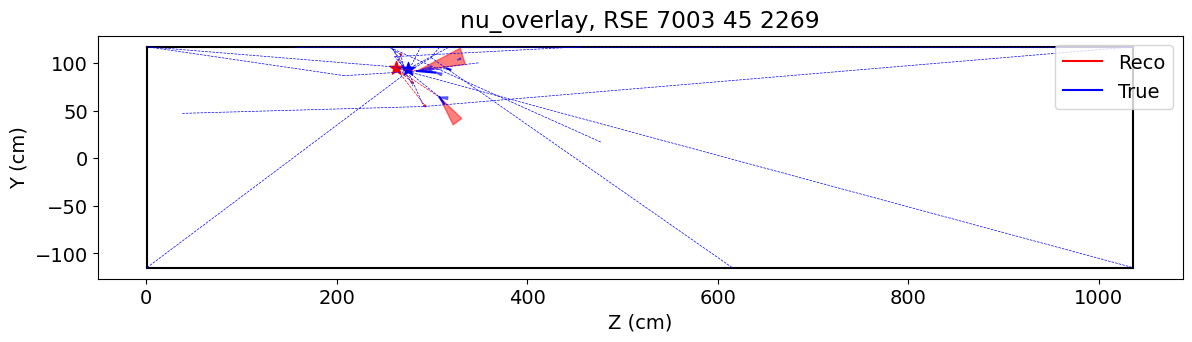

In [19]:
file = one_event_df["file"].to_numpy()[0]
run = one_event_df["run"].to_numpy()[0]
subrun = one_event_df["subrun"].to_numpy()[0]
event = one_event_df["event"].to_numpy()[0]

reco_ids = one_event_df["reco_id"].to_numpy()[0]
reco_pdgs = one_event_df["reco_pdg"].to_numpy()[0]
reco_start_XYZTs = one_event_df["reco_startXYZT"].to_numpy()[0]
reco_end_XYZTs = one_event_df["reco_endXYZT"].to_numpy()[0]

truth_ids = one_event_df["truth_id"].to_numpy()[0]
truth_pdgs = one_event_df["truth_pdg"].to_numpy()[0]
truth_start_XYZTs = one_event_df["truth_startXYZT"].to_numpy()[0]
truth_end_XYZTs = one_event_df["truth_endXYZT"].to_numpy()[0]

tpc_min_x = -1.
tpc_max_x = 254.3
tpc_min_y = -115.
tpc_max_y = 117.
tpc_min_z = 0.6
tpc_max_z = 1036.4

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(14, 6))
plt.plot([tpc_min_z, tpc_max_z], [tpc_min_y, tpc_min_y], c="k")
plt.plot([tpc_min_z, tpc_max_z], [tpc_max_y, tpc_max_y], c="k")
plt.plot([tpc_min_z, tpc_min_z], [tpc_min_y, tpc_max_y], c="k")
plt.plot([tpc_max_z, tpc_max_z], [tpc_min_y, tpc_max_y], c="k")
plt.plot([], [], c="r", label="Reco")
plt.plot([], [], c="b", label="True")
for j in range(len(reco_pdgs)):
    start_x, start_y, start_z, start_t = reco_start_XYZTs[j]
    end_x, end_y, end_z, end_t = reco_end_XYZTs[j]
    pdg = reco_pdgs[j]
    if Particle.from_pdgid(pdg).charge == 0: # invisible particle, draw dashed line
        plt.plot([start_z, end_z], [start_y, end_y], c="r", linestyle="--", lw=0.5)
    elif pdg == 11: # shower, plot cone
        start = np.array([start_z, start_y])
        end = np.array([end_z, end_y])
        direction = end - start
        length = np.linalg.norm(direction)
        unit_direction = direction / length
        perp = np.array([-unit_direction[1], unit_direction[0]])
        angle_rad = np.radians(20 / 2)
        side_length = length * np.tan(angle_rad)
        side1 = end - side_length * perp
        side2 = end + side_length * perp
        triangle = np.array([start, side1, end, side2])
        plt.fill(triangle[:, 0], triangle[:, 1], color="r", alpha=0.5)
    else: # track, plot line
        plt.plot([start_z, end_z], [start_y, end_y], c="r")
for j in range(len(truth_pdgs)):
    start_x, start_y, start_z, start_t = truth_start_XYZTs[j]
    end_x, end_y, end_z, end_t = truth_end_XYZTs[j]
    start_x = np.clip(start_x, tpc_min_x, tpc_max_x)
    start_y = np.clip(start_y, tpc_min_y, tpc_max_y)
    start_z = np.clip(start_z, tpc_min_z, tpc_max_z)
    end_x = np.clip(end_x, tpc_min_x, tpc_max_x)
    end_y = np.clip(end_y, tpc_min_y, tpc_max_y)
    end_z = np.clip(end_z, tpc_min_z, tpc_max_z)
    pdg = truth_pdgs[j]
    if Particle.from_pdgid(pdg).charge == 0: # invisible particle, draw dashed line
        plt.plot([start_z, end_z], [start_y, end_y], c="b", linestyle="--", lw=0.5)
    elif pdg == 11: # shower, plot cone
        start = np.array([start_z, start_y])
        end = np.array([end_z, end_y])
        direction = end - start
        length = np.linalg.norm(direction)
        unit_direction = direction / length
        perp = np.array([-unit_direction[1], unit_direction[0]])
        angle_rad = np.radians(20 / 2)
        side_length = length * np.tan(angle_rad)
        side1 = end - side_length * perp
        side2 = end + side_length * perp
        triangle = np.array([start, side1, end, side2])
        plt.fill(triangle[:, 0], triangle[:, 1], color="b", alpha=0.5)
    else: # track, plot line
        plt.plot([start_z, end_z], [start_y, end_y], c="b")
plt.scatter(one_event_df["reco_nuvtxZ"].to_numpy()[0], one_event_df["reco_nuvtxY"].to_numpy()[0], color="r", marker="*", s=100)
plt.scatter(one_event_df["truth_vtxZ"].to_numpy()[0], one_event_df["truth_vtxY"].to_numpy()[0], color="b", marker="*", s=100)
plt.title(f"{file}, RSE {run} {subrun} {event}")
plt.legend(loc="upper right")
plt.xlabel("Z (cm)")
plt.ylabel("Y (cm)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
